# **CREDIT SCORING** : Prédire le risque de défaut de paiement pour les demandes de prêt presonnel

# 1. BUSINESS UNDERSTANDING

Modèle de credit scoring qui :
- Prédit la probabilité de défaut à l'**octroi** du crédit
- Maximise le profit en acceptant les bons clients et refusant le mauvais
- Respecte les contraintes règlementaires (inteprétabilité, équité)

TYPE DE PROBLEME :
- Apprentissage supervisé : **Classification binaire** ( défaut : 1, Pas de défaut : 0)
- Contraintes : 
    * classes déséquilibrées (minorité = défaut)
    * pas de variables discriminatoires
    * latence de prédiction < 1s
    * explicabilité requise (secteur bancaire)

METRIQUES CLES :
- ML : insensible au déséquilibre --> **auc-roc**
- Business : profit attendu 
    * accepter bon client : intérêts (ex : +montants) --> **TP**
    * refuser bon client : manque à gagner (ex : -montants) --> **FP**
    * accepter mauvais client : perte moyenne (ex : -montants considérables) --> **FN**
    * refuser mauvais client : 0 --> **TN**

HORIZON DE PREDICTION :
Prédire le risque sur **toute la durée du prêt**

# 2. PACKAGES + DATA UNDERSTANDING

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import shap
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer,make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score,
f1_score,accuracy_score, precision_score, recall_score,brier_score_loss)
from sklearn.inspection import permutation_importance
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from scipy import stats
from scipy.stats import chi2_contingency
import joblib
import json
from datetime import datetime

In [2]:
# dataset
colnames = ['status_checking_account','duration_months','credit_history','purpose',
               'credit_amount', 'savings_account', 'employment_since', 'installment-rate',
               'personal_status_sex', 'other_debtors', 'residence_since', 'property',
               'age', 'other_installment_plans', 'housing', 'num_existing_credits',
               'job', 'num_dependents', 'telephone', 'foreign_worker', 'target']
data =  pd.read_csv('data/statlog+german+credit+data/german.data', sep=' ', names=colnames, header=None)

In [3]:
# aperçu
data.head()

,status_checking_account,duration_months,credit_history,purpose,credit_amount,savings_account,employment_since,installment-rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,num_existing_credits,job,num_dependents,telephone,foreign_worker,target
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


In [4]:
# dimension
data.shape

(1000, 21)

In [5]:
data['target']=data['target'].map({1:0,2:1})
data.head()

,status_checking_account,duration_months,credit_history,purpose,credit_amount,savings_account,employment_since,installment-rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,num_existing_credits,job,num_dependents,telephone,foreign_worker,target
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,0
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,1
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,0
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,0
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,1


In [6]:
df = data.copy()

In [7]:
# information globale
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   status_checking_account  1000 non-null   object
 1   duration_months          1000 non-null   int64 
 2   credit_history           1000 non-null   object
 3   purpose                  1000 non-null   object
 4   credit_amount            1000 non-null   int64 
 5   savings_account          1000 non-null   object
 6   employment_since         1000 non-null   object
 7   installment-rate         1000 non-null   int64 
 8   personal_status_sex      1000 non-null   object
 9   other_debtors            1000 non-null   object
 10  residence_since          1000 non-null   int64 
 11  property                 1000 non-null   object
 12  age                      1000 non-null   int64 
 13  other_installment_plans  1000 non-null   object
 14  housing                  1000 non-null   

In [8]:
# statistique globale
df.describe(include='all')

,status_checking_account,duration_months,credit_history,purpose,credit_amount,savings_account,employment_since,installment-rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,num_existing_credits,job,num_dependents,telephone,foreign_worker,target
count,1000,1000.000000,1000,1000,1000.000000,1000,1000,1000.000000,1000,1000,...,1000,1000.000000,1000,1000,1000.000000,1000,1000.000000,1000,1000,1000.000000
unique,4,NaN,5,10,NaN,5,5,NaN,4,3,...,4,NaN,3,3,NaN,4,NaN,2,2,NaN
top,A14,NaN,A32,A43,NaN,A61,A73,NaN,A93,A101,...,A123,NaN,A143,A152,NaN,A173,NaN,A191,A201,NaN
freq,394,NaN,530,280,NaN,603,339,NaN,548,907,...,332,NaN,814,713,NaN,630,NaN,596,963,NaN
mean,NaN,20.903000,NaN,NaN,3271.258000,NaN,NaN,2.973000,NaN,NaN,...,NaN,35.546000,NaN,NaN,1.407000,NaN,1.155000,NaN,NaN,0.300000
std,NaN,12.058814,NaN,NaN,2822.736876,NaN,NaN,1.118715,NaN,NaN,...,NaN,11.375469,NaN,NaN,0.577654,NaN,0.362086,NaN,NaN,0.458487
min,NaN,4.000000,NaN,NaN,250.000000,NaN,NaN,1.000000,NaN,NaN,...,NaN,19.000000,NaN,NaN,1.000000,NaN,1.000000,NaN,NaN,0.000000
25%,NaN,12.000000,NaN,NaN,1365.500000,NaN,NaN,2.000000,NaN,NaN,...,NaN,27.000000,NaN,NaN,1.000000,NaN,1.000000,NaN,NaN,0.000000
50%,NaN,18.000000,NaN,NaN,2319.500000,NaN,NaN,3.000000,NaN,NaN,...,NaN,33.000000,NaN,NaN,1.000000,NaN,1.000000,NaN,NaN,0.000000
75%,NaN,24.000000,NaN,NaN,3972.250000,NaN,NaN,4.000000,NaN,NaN,...,NaN,42.000000,NaN,NaN,2.000000,NaN,1.000000,NaN,NaN,1.000000


In [9]:
# valeurs manquantes
df.isnull().sum()/len(df) * 100

status_checking_account    0.0
duration_months            0.0
credit_history             0.0
purpose                    0.0
credit_amount              0.0
savings_account            0.0
employment_since           0.0
installment-rate           0.0
personal_status_sex        0.0
other_debtors              0.0
residence_since            0.0
property                   0.0
age                        0.0
other_installment_plans    0.0
housing                    0.0
num_existing_credits       0.0
job                        0.0
num_dependents             0.0
telephone                  0.0
foreign_worker             0.0
target                     0.0
dtype: float64

Pas de valeurs manquantes

In [10]:
# doublons
df.duplicated().sum()

np.int64(0)

Pas de doublons

# 3. EDA

## 3.1. ANALYSE UNIVARIEE

DISTRIBUTION DE LA VARIABLE CIBLE

In [11]:
df['target'].value_counts(normalize=True)

target
0    0.7
1    0.3
Name: proportion, dtype: float64

In [12]:
# taux de défaut
print(f'Taux de défaut : {df['target'].mean():.2%}')

Taux de défaut : 30.00%


Le taux de défaut n'est pas très basse ni trop élevé --> classe désequilibrée mais pas assez pour s'inquiéter des biais

In [13]:
# ratio de déséquilibre
print(f'Ratio de déséquilibre : {df['target'].value_counts(normalize=True)[0]/df['target'].value_counts(normalize=True)[1]:.2f}')

Ratio de déséquilibre : 2.33


Ratio de déséquilibre n'est pas > 10 

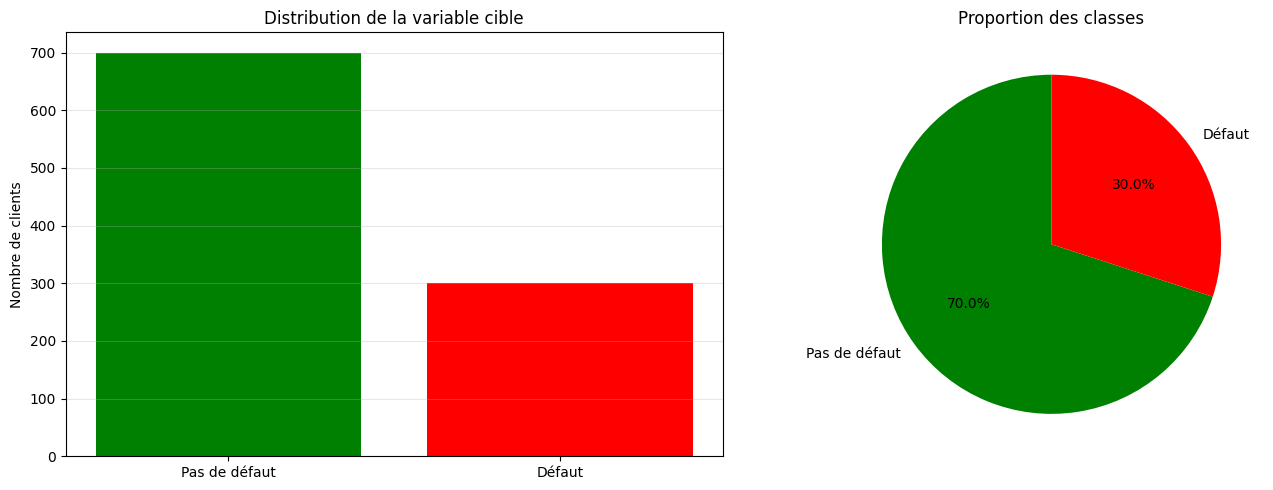

In [14]:
fig, axes = plt.subplots(1,2, figsize=(14,5))

axes[0].bar(['Pas de défaut', 'Défaut'], df['target'].value_counts().values, color=['green', 'red'])
axes[0].set_ylabel('Nombre de clients')
axes[0].set_title('Distribution de la variable cible')
axes[0].grid(axis='y', alpha=0.3)

axes[1].pie(df['target'].value_counts().values, labels=['Pas de défaut', 'Défaut'], autopct='%1.1f%%', colors=['green','red'], startangle=90)
axes[1].set_title('Proportion des classes')

plt.tight_layout()
plt.show()

DISTRIBUTION DES FEATURES NUMERIQUES

In [15]:
numeric_cols = df.select_dtypes(include='number').columns.to_list()
numeric_cols.remove('target')

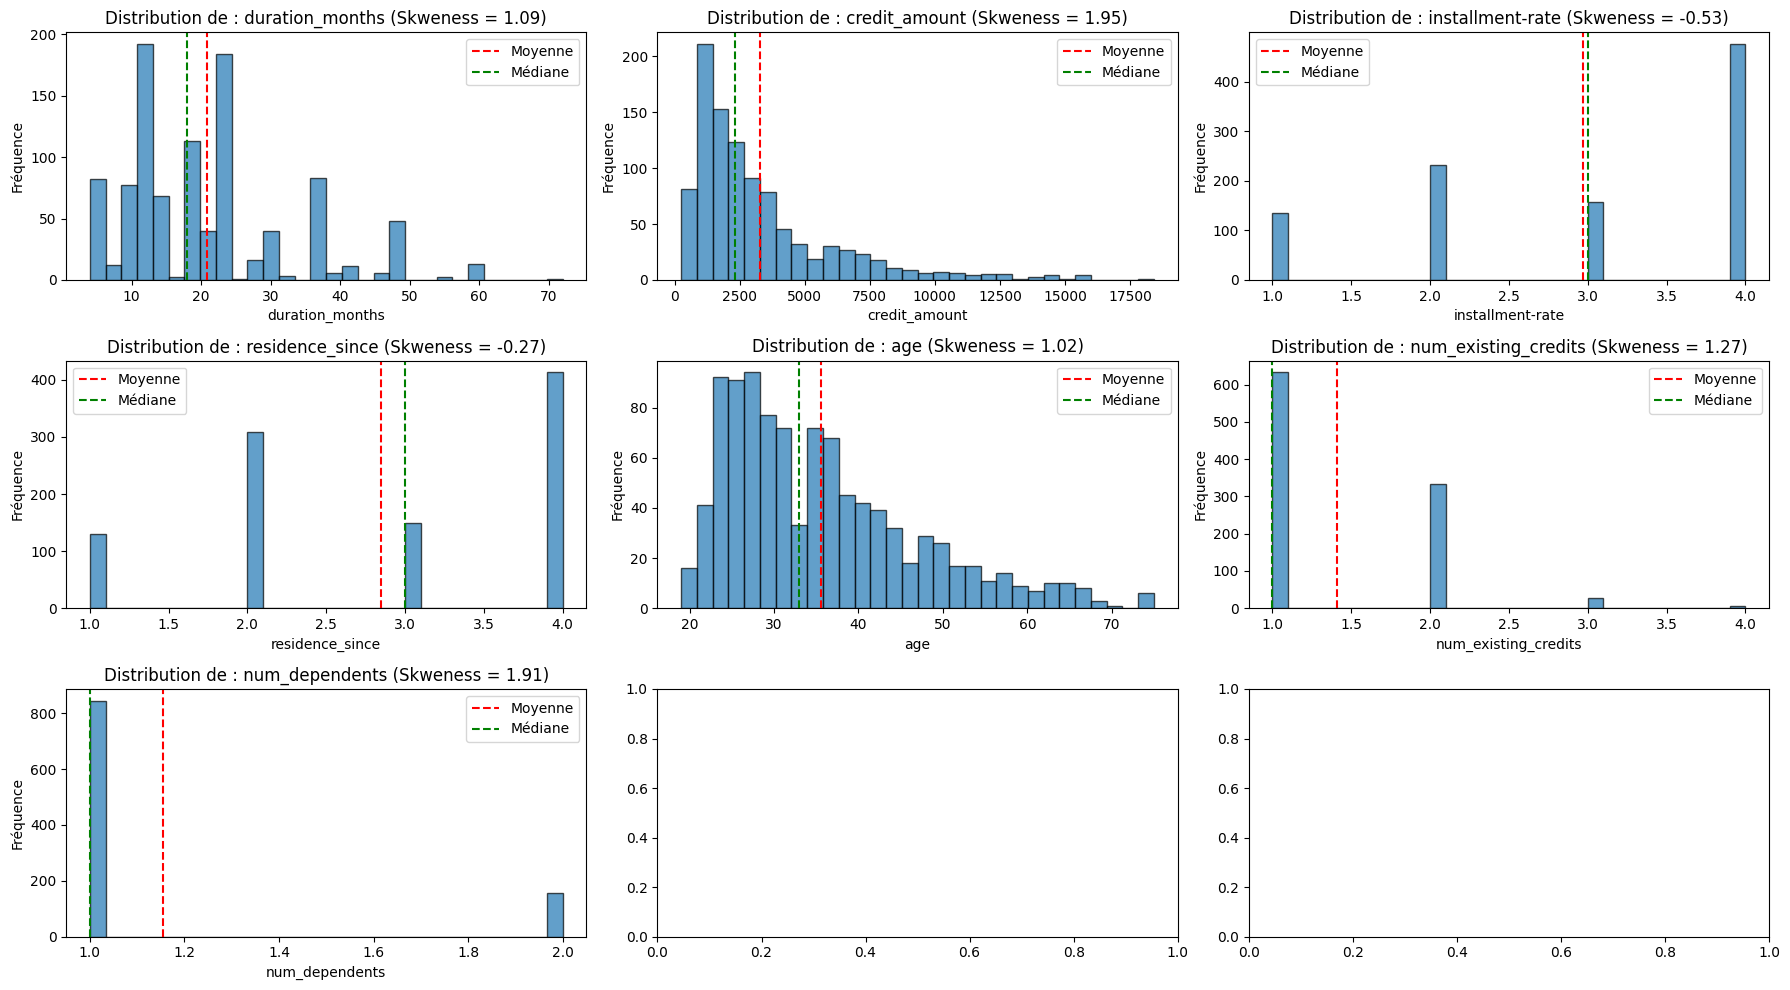

In [16]:
fig, axes = plt.subplots(3,3, figsize=(18,10))
axes = axes.ravel()

for i, col in enumerate(numeric_cols) :
    axes[i].hist(df[col], bins=30, edgecolor='black', alpha=0.7)
    axes[i].set_title(f'Distribution de : {col} (Skweness = {df[col].skew():.2f})')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Fréquence')
    axes[i].axvline(df[col].mean(), color='red', ls='--', label='Moyenne')
    axes[i].axvline(df[col].median(), color='green', ls='--', label='Médiane')
    axes[i].legend()
    
plt.tight_layout()
plt.show()
    

Certaines variables sont très asymétriques (skewness > 1) avec de longue queue ( vers grande valeur positive) --> transformation

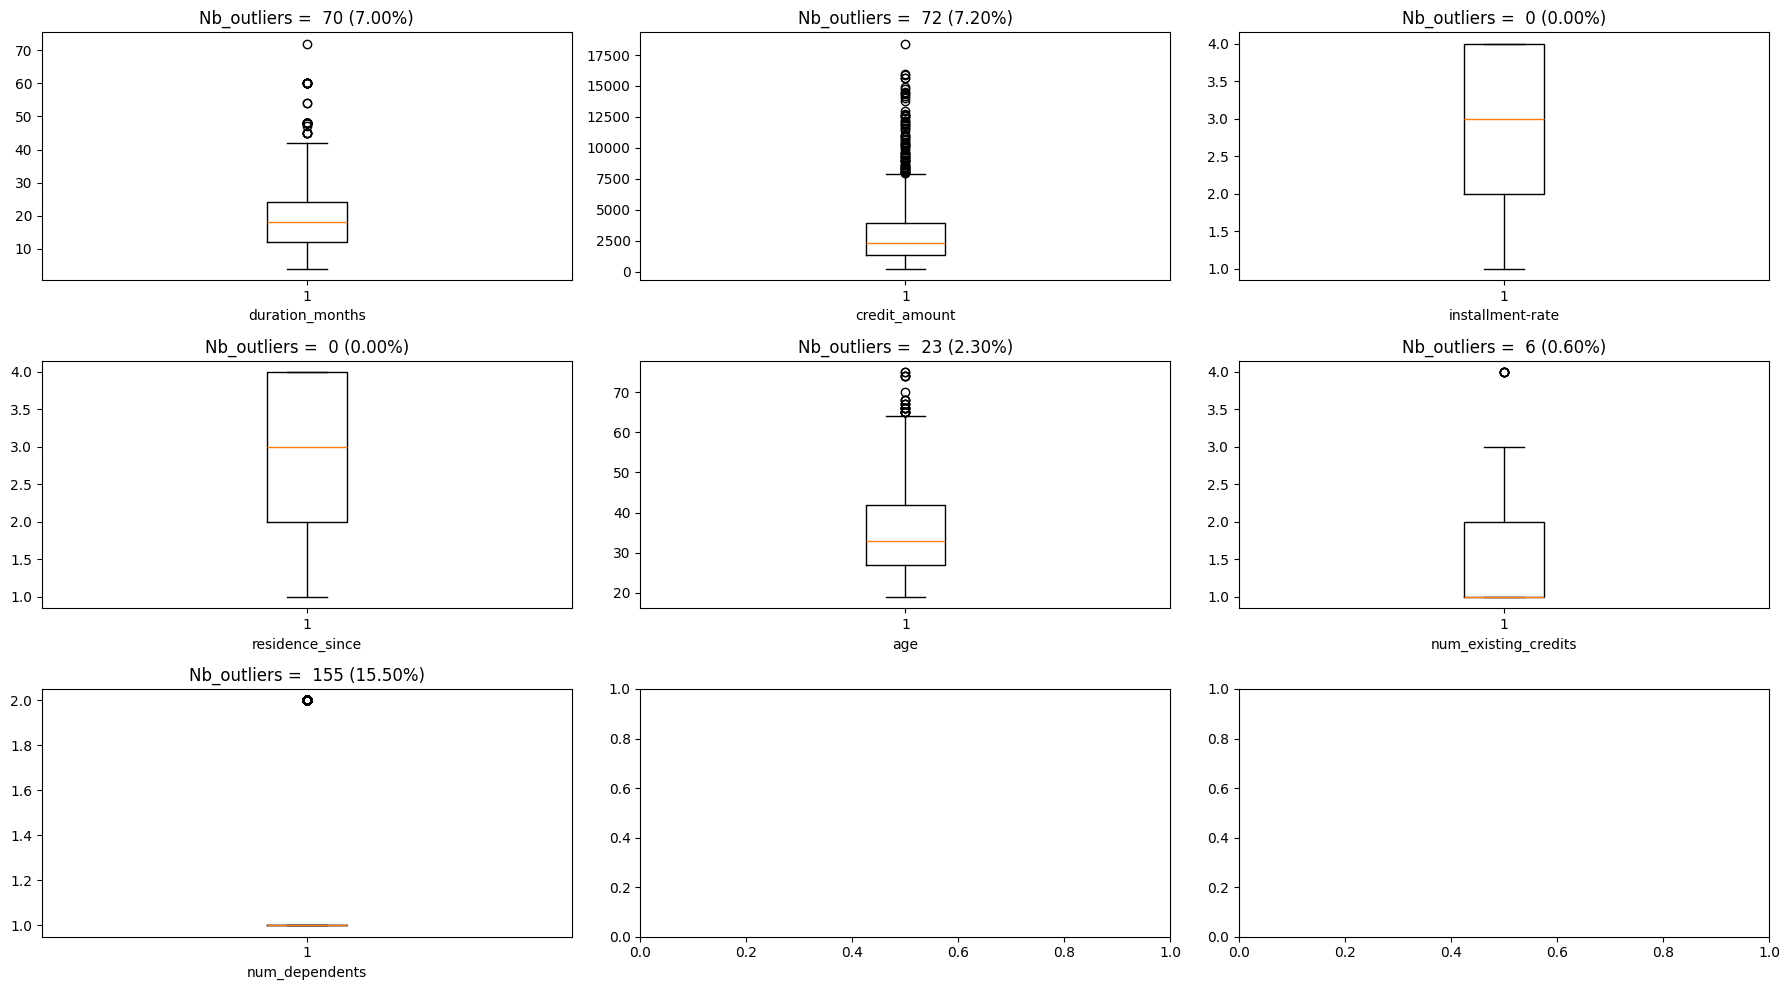

In [17]:
# v+aleurs aberrantes
fig, axes = plt.subplots(3,3, figsize=(18,10))
axes = axes.ravel()

for i, col in enumerate(numeric_cols) :
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
    outliers_pct = (outliers / len(df) * 100)
    
    axes[i].boxplot(df[col])
    axes[i].set_title(f"Nb_outliers =  {outliers} ({outliers_pct:.2f}%)")
    axes[i].set_xlabel(col)
        
plt.tight_layout()
plt.show()

Présence d'outliers --> vérifié par l'asymétrie --> à traiter si impact

DISTRIBUTION DES FEATURES CATEGORIELLES

In [18]:
cat_cols = df.select_dtypes(include='object').columns.to_list()

In [19]:
mapping = {
    "A11" : "... < 0 DM",
	"A12" : "0 <= ... < 200 DM",
	"A13" : "... >= 200 DM / salary assignments for at least 1 year",
    "A14" : "no checking account",
    "A30" : "no credits taken / all credits paid back duly",
    "A31" : "all credits at this bank paid back duly",
	"A32" : "existing credits paid back duly till now",
    "A33" : "delay in paying off in the past",
	"A34" : "critical account / other credits existing (not at this bank)",
    "A40" : "car (new)",
	"A41" : "car (used)",
	"A42" : "furniture/equipment",
	"A43" : "radio/television",
	"A44" : "domestic appliances",
    "A45" : "repairs",
    "A46" : "education",
    "A47" : "(vacation - does not exist?)",
    "A48" : "retraining",
    "A49" : "business",
    "A410" : "others",
    "A61" : "... <  100 DM",
    "A62" : "100 <= ... <  500 DM",
    "A63" : "500 <= ... < 1000 DM",
    "A64" : "... >= 1000 DM",
    "A65" : "unknown/ no savings account",
    "A71" : "unemployed",
    "A72" : "... < 1 year",
    "A73" : "1 <= ... < 4 years", 
    "A74" : "4 <= ... < 7 years",
    "A75" : "... >= 7 years",
    "A91" : "male : divorced / separated",
	"A92" : "female : divorced / separated / married",
    "A93" : "male : single",
    "A94" : "male : married / widowed",
    "A95" : "female : single",
    "A101" : "none",
    "A102" : "co-applicant",
    "A103" : "guarantor",
    "A121" : "real estate",
	"A122" : "building society savings agreement / life insurance", # if not A121 : building society savings agreement / life insurance
    "A123" : "car or other", #if not A121/A122 : car or other, not in attribute 6
	"A124" : "unknown / no property",
    "A141" : "bank",
	"A142" : "stores",
	"A143" : "none",
    "A151" : "rent",
	"A152" : "own",
	"A153" : "for free",
    "A171" : "unemployed / unskilled - non-resident",
	"A172" : "unskilled - resident",
	"A173" : "skilled employee / official",
	"A174" : "management/ self-employed / highly qualified employee/ officer",
    "A191" : "none",
	"A192" : "yes, registered under the customers name",
    "A201" : "yes",
	"A202" : "no"
}

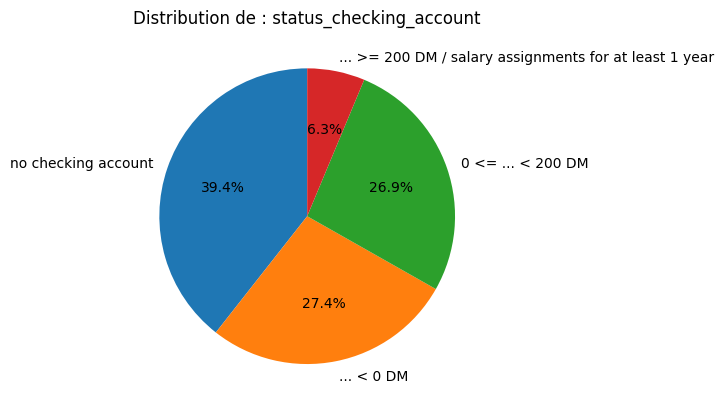

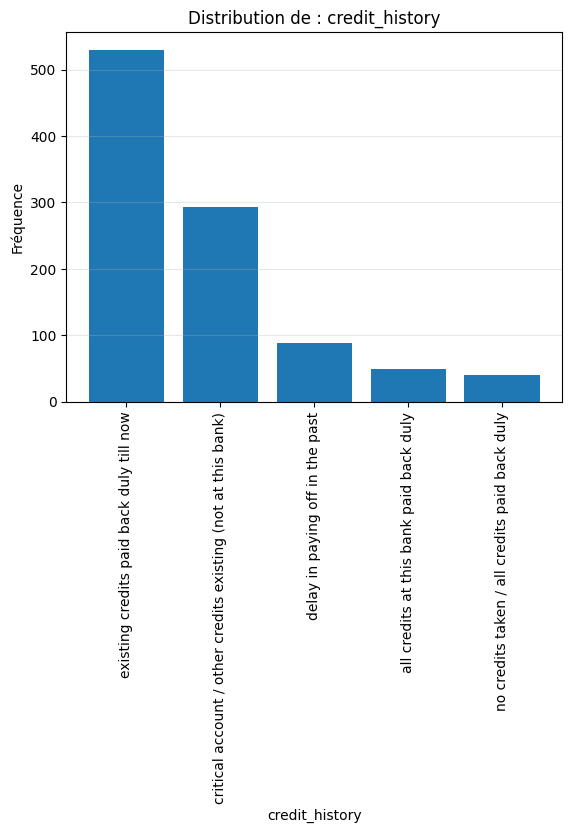

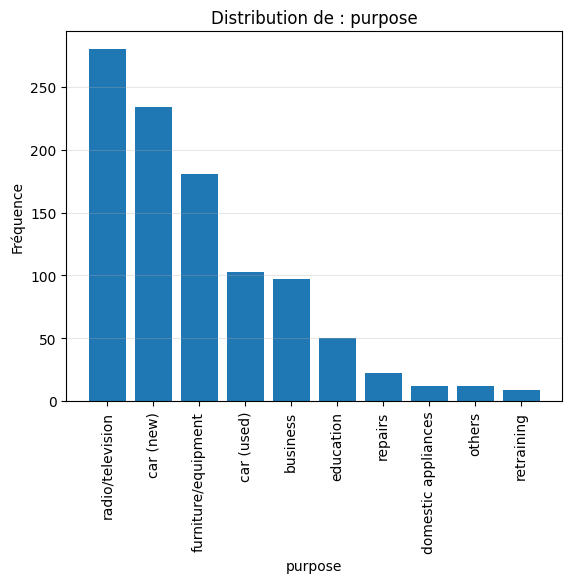

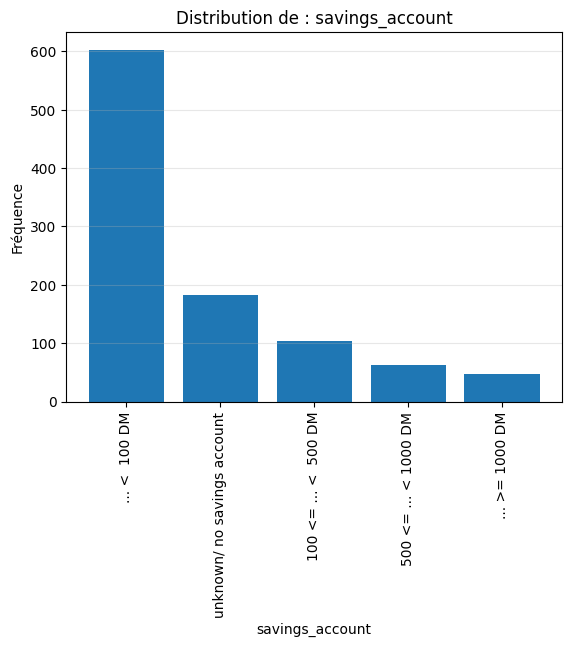

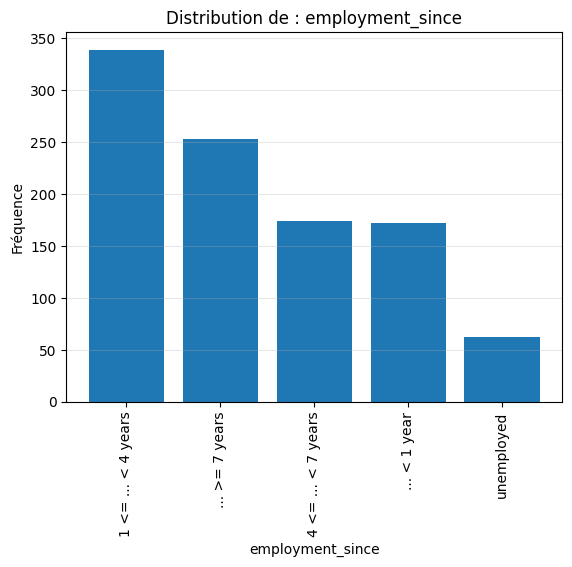

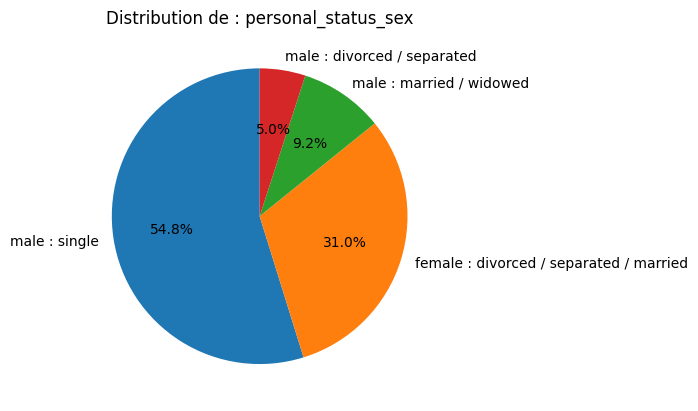

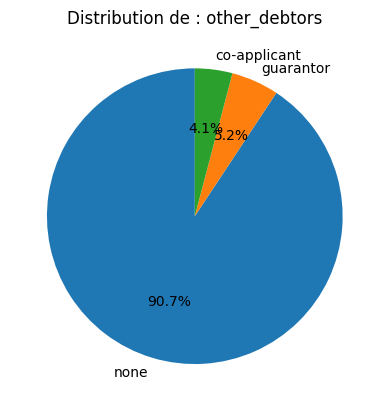

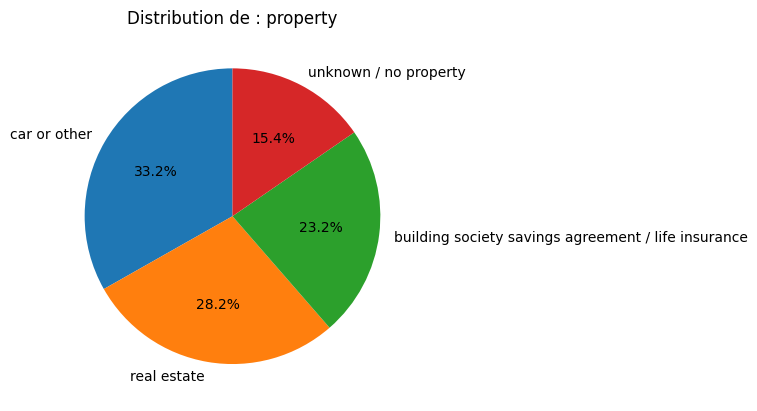

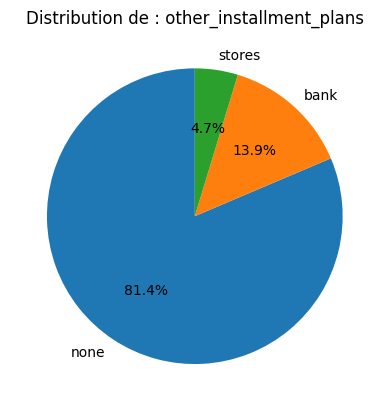

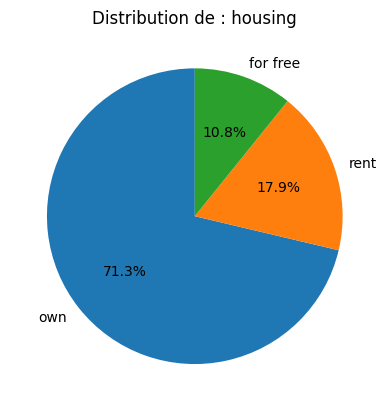

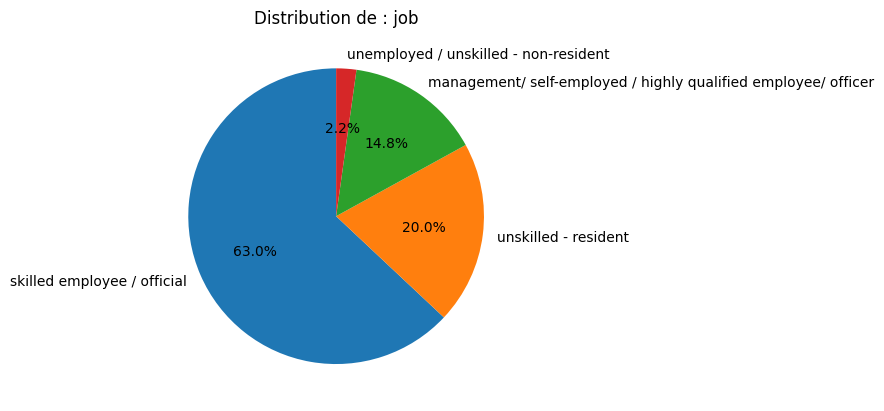

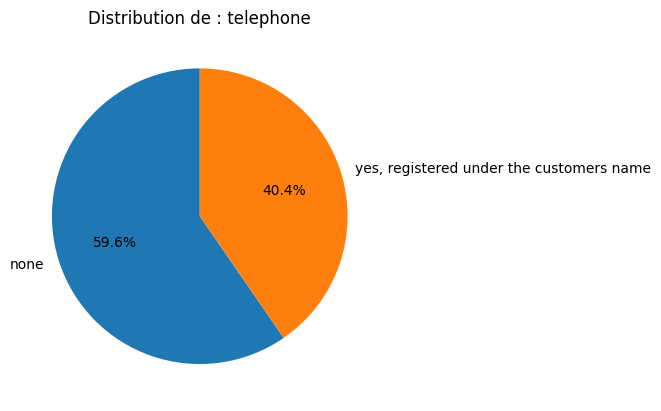

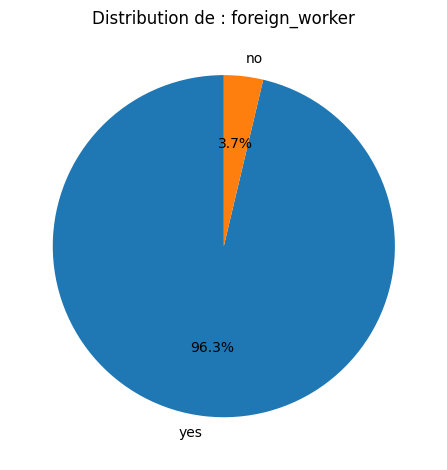

In [20]:
for col in cat_cols :
    fig, ax = plt.subplots(1,1)
    if df[col].nunique() < 5 :
        ax.pie(df[col].value_counts().values, labels=df[col].map(mapping).value_counts().index, autopct='%1.1f%%', startangle=90)
        ax.set_title(f"Distribution de : {col}")
    else :
        ax.bar(df[col].map(mapping).value_counts().index,df[col].value_counts().values)
        ax.set_ylabel('Fréquence')
        ax.set_xlabel(col)
        ax.set_title(f"Distribution de : {col}")
        ax.grid(axis='y', alpha=0.3)
        ax.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

## 3.2. ANALYSE BIVARIEE (feature vs target)

VARIABLES NUMERIQUES VS TARGET (VARIABLE CATEGORIELLE)

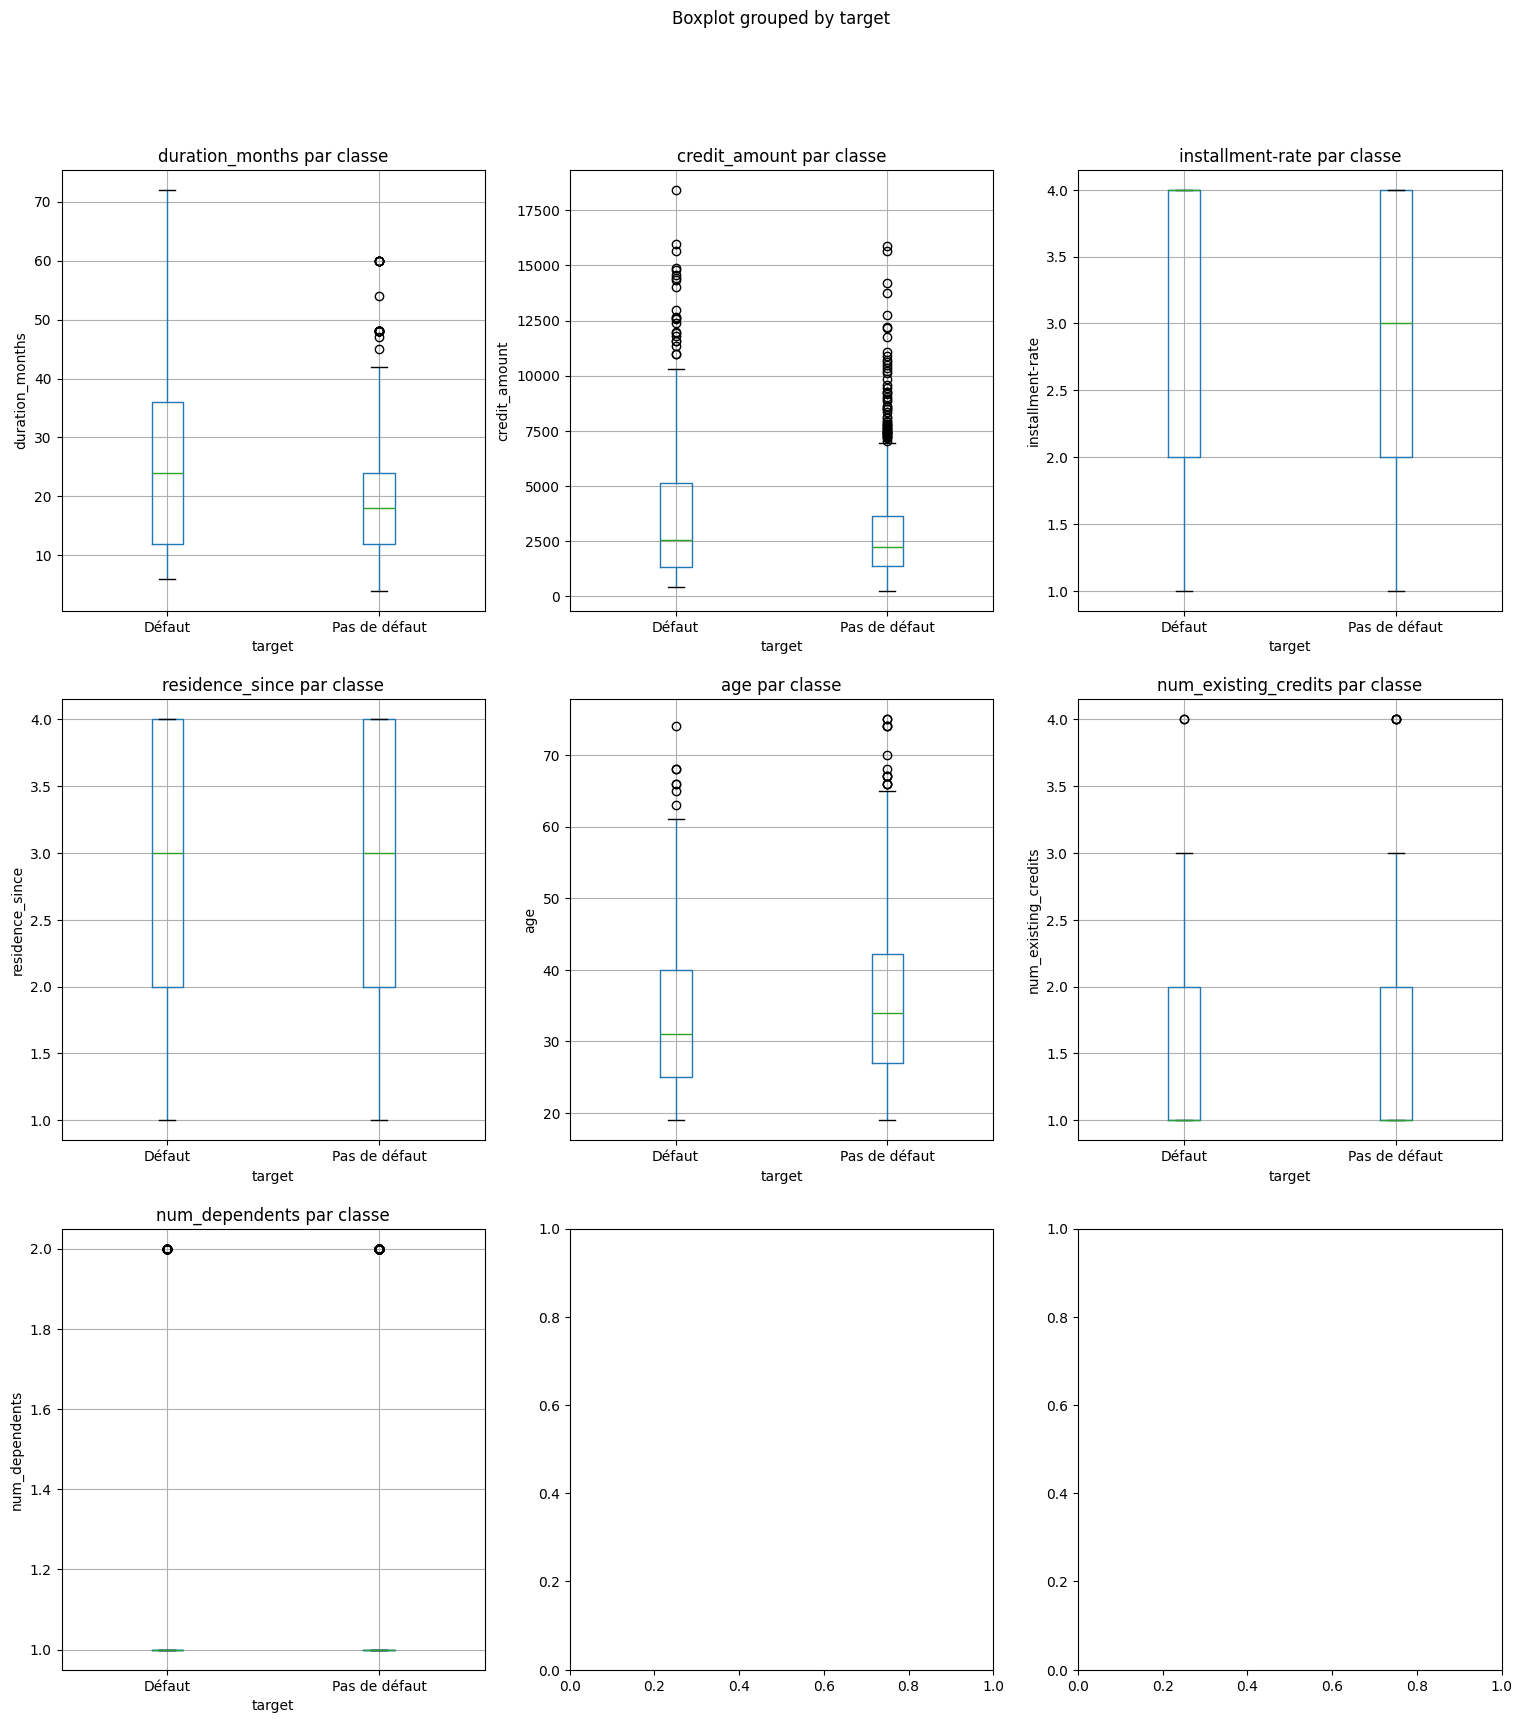

In [21]:
fig, axes = plt.subplots(3,3, figsize=(18,20))
axes = axes.ravel()
df1 = df.copy()
df1['target'] = df1['target'].map({0: 'Pas de défaut', 1:'Défaut'})
for i, col in enumerate(numeric_cols) :
    df1.boxplot(col, by='target', ax=axes[i])
    axes[i].set_title(f"{col} par classe")
    axes[i].set_ylabel(col)
    

Certaines variables influencent la variable cible

In [22]:
comparison = df.groupby('target')[numeric_cols].mean().T
comparison.columns = ['pas de défaut','défaut']
comparison['ratio'] = (comparison['défaut'] / comparison['pas de défaut']).round(2)
comparison= comparison.sort_values('ratio', ascending=False)
comparison

,pas de défaut,défaut,ratio
credit_amount,2985.457143,3938.126667,1.32
duration_months,19.207143,24.860000,1.29
installment-rate,2.920000,3.096667,1.06
residence_since,2.842857,2.850000,1.00
num_dependents,1.155714,1.153333,1.00
num_existing_credits,1.424286,1.366667,0.96
age,36.224286,33.963333,0.94


In [23]:
# tests statistiques (test de student)

for col in numeric_cols:
    group0 = df[df['target'] == 0][col]
    group1 = df[df['target'] == 1][col]
    
    stat, p_value = stats.ttest_ind(group0, group1)
    print(f"\n {col:.<80}")
    print(f"Moyenne (Pas de défaut) : {group0.mean():.2f}")
    print(f"Moyenne (Défaut) : {group1.mean():.2f}")
    print(f"t-statistic : {stat:.2f}")
    print(f"p_value : {p_value:.4f}")
    
    if p_value < 0.05:
        print("Différence significatie (variable prédictive)")
    else :
        print("Pas de différence significative")


 duration_months.................................................................
Moyenne (Pas de défaut) : 19.21
Moyenne (Défaut) : 24.86
t-statistic : -6.95
p_value : 0.0000
Différence significatie (variable prédictive)

 credit_amount...................................................................
Moyenne (Pas de défaut) : 2985.46
Moyenne (Défaut) : 3938.13
t-statistic : -4.95
p_value : 0.0000
Différence significatie (variable prédictive)

 installment-rate................................................................
Moyenne (Pas de défaut) : 2.92
Moyenne (Défaut) : 3.10
t-statistic : -2.29
p_value : 0.0220
Différence significatie (variable prédictive)

 residence_since.................................................................
Moyenne (Pas de défaut) : 2.84
Moyenne (Défaut) : 2.85
t-statistic : -0.09
p_value : 0.9253
Pas de différence significative

 age.............................................................................
Moyenne (Pas de défaut) : 36.22
Moyenne

Trois variables n'influencent pas la variable cible :  num_dependents, num_existing_credits, residence_since

VARIABLES CATEGORIELLES VS TARGET (VARIABLE CATEGORIELLE)

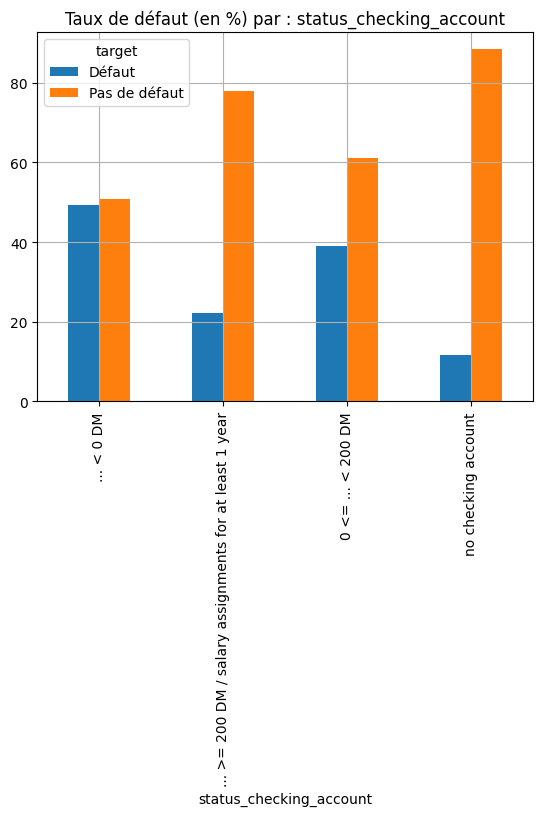

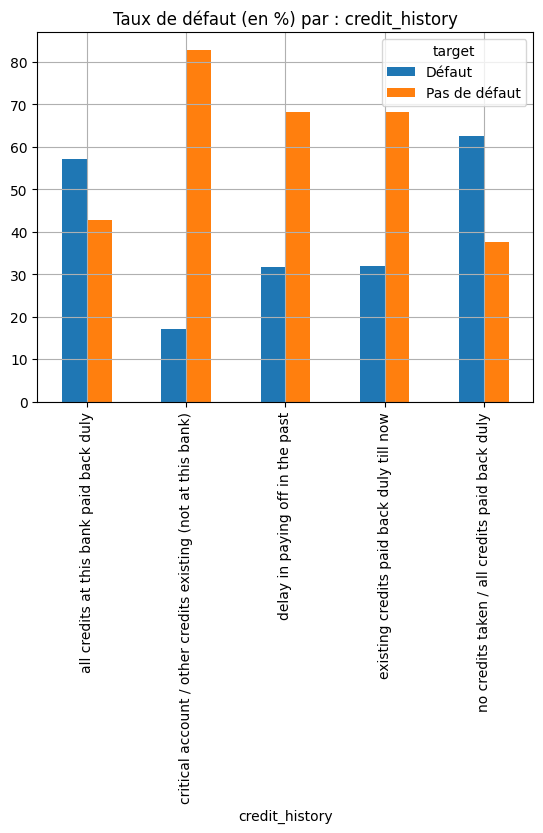

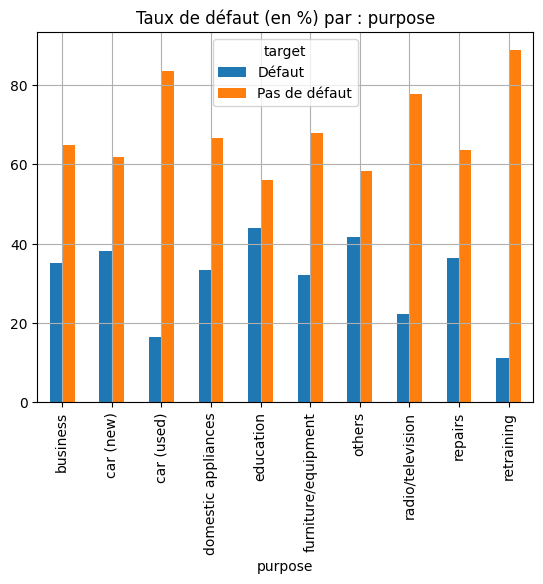

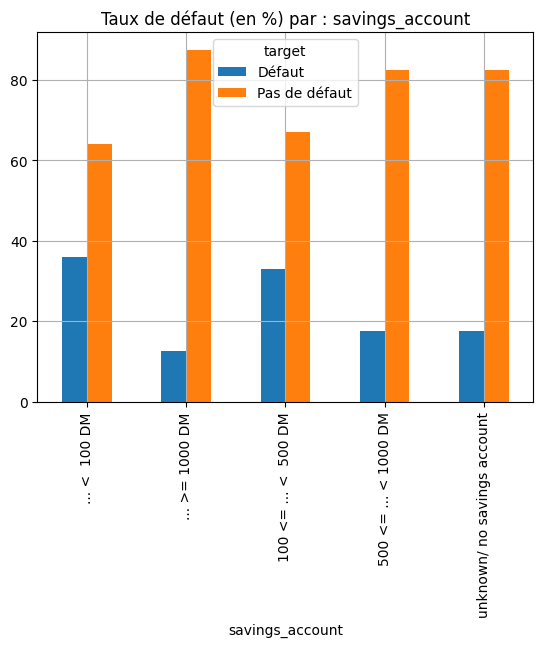

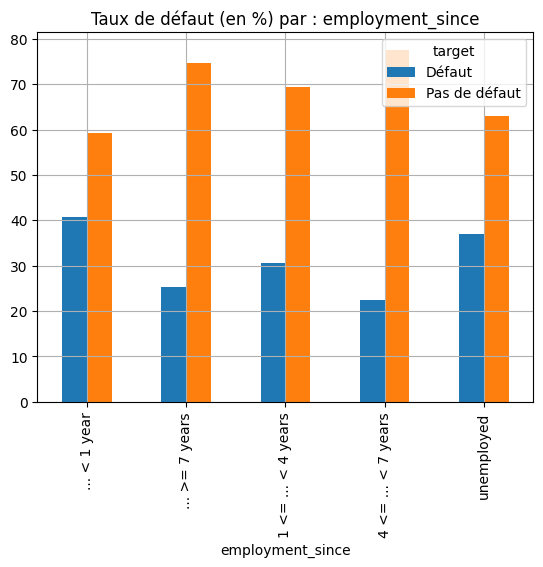

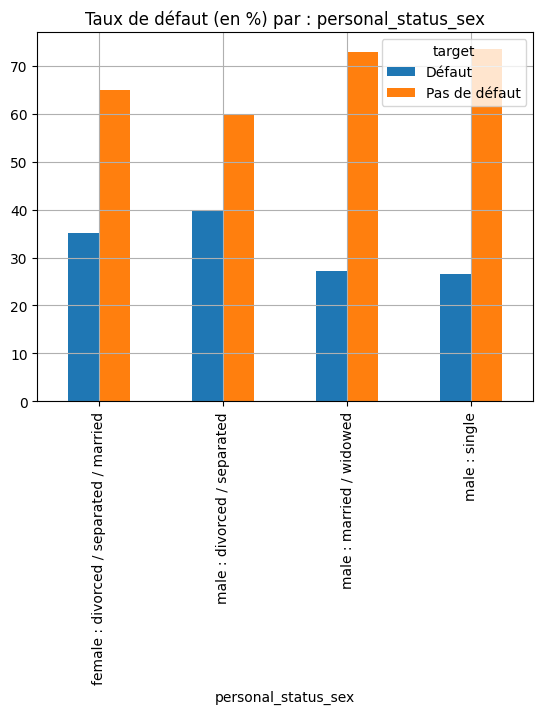

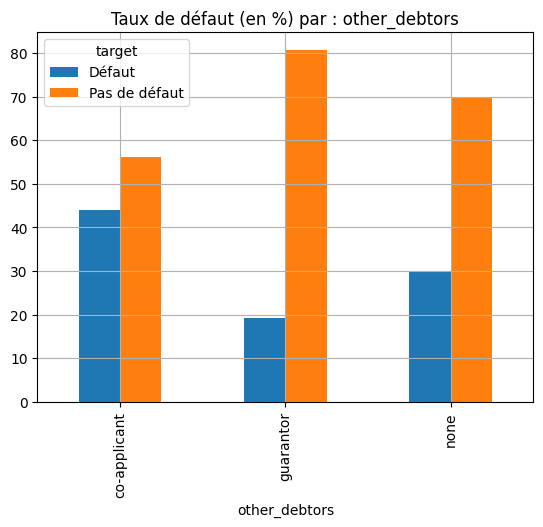

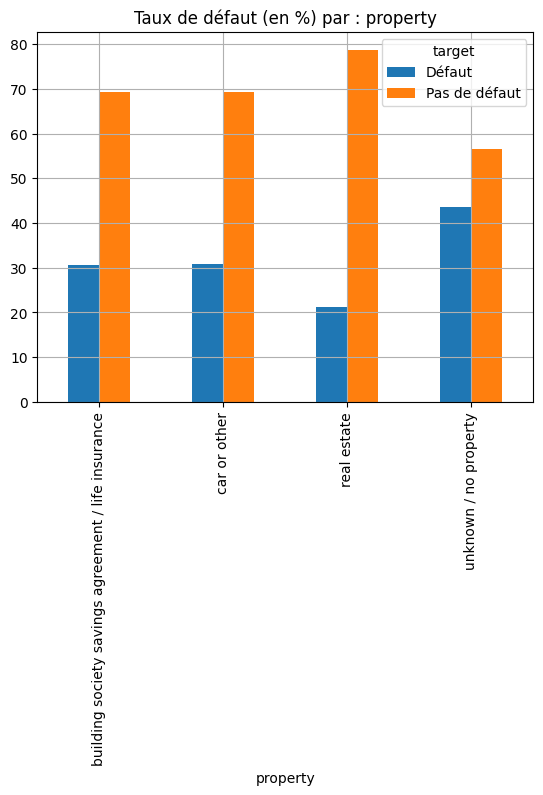

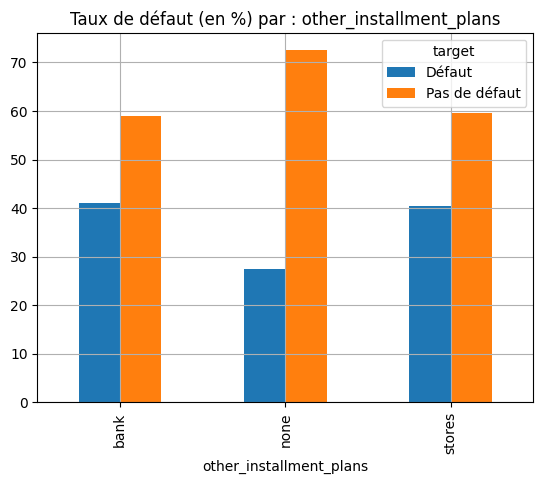

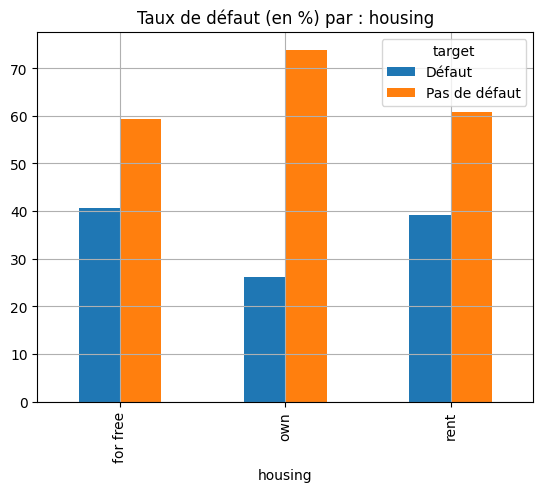

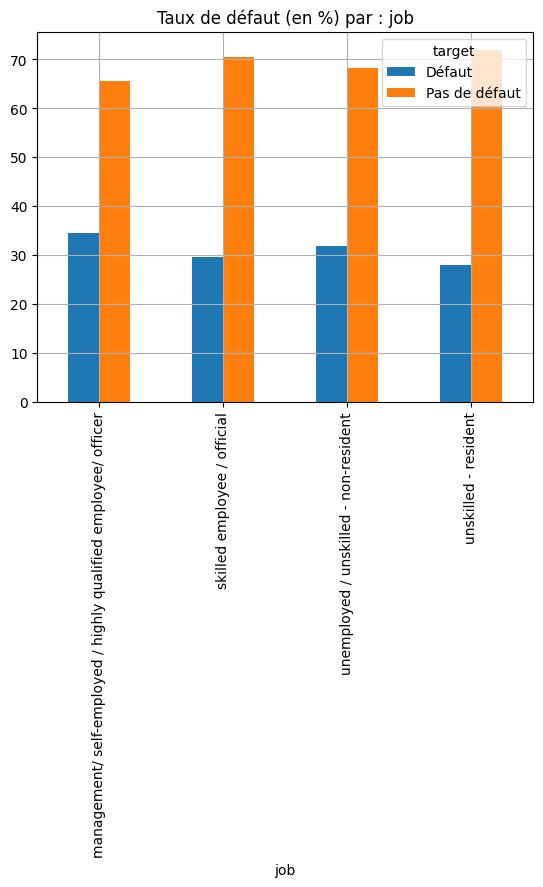

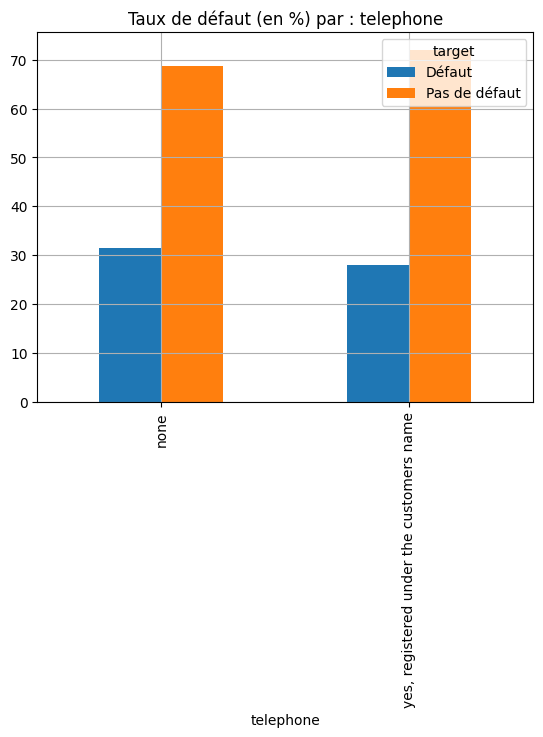

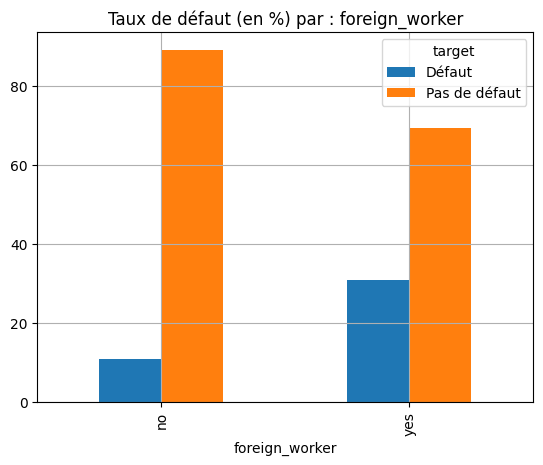

In [24]:
for col in cat_cols :
    crosstab = pd.crosstab(df[col].map(mapping), df['target'].map({0: 'Pas de défaut', 1:'Défaut'}), normalize='index') *100
    crosstab.plot(kind='bar', grid=True, title=f'Taux de défaut (en %) par : {col}')

In [25]:
# test statiqtique (test de chi2)
for col in cat_cols : 
    contingency_table = pd.crosstab(df[col], df['target'])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    print(f"\n {col:.<80}")
    print(f"chi2 = {chi2:.2f}, p_value = {p_value:.4f}")
    
    if p_value < 0.05 :
        print("Association significative avec target")
    else:
        print("Pas d'association significative")


 status_checking_account.........................................................
chi2 = 123.72, p_value = 0.0000
Association significative avec target

 credit_history..................................................................
chi2 = 61.69, p_value = 0.0000
Association significative avec target

 purpose.........................................................................
chi2 = 33.36, p_value = 0.0001
Association significative avec target

 savings_account.................................................................
chi2 = 36.10, p_value = 0.0000
Association significative avec target

 employment_since................................................................
chi2 = 18.37, p_value = 0.0010
Association significative avec target

 personal_status_sex.............................................................
chi2 = 9.61, p_value = 0.0222
Association significative avec target

 other_debtors...................................................................
chi2 

Presque toutes les variabes ont une association avec la variable cible sauf : telephone et job

## 3.3. ANALYSE MULTIVARIEE

In [26]:
corr_matrix = df[numeric_cols + ['target']].corr()

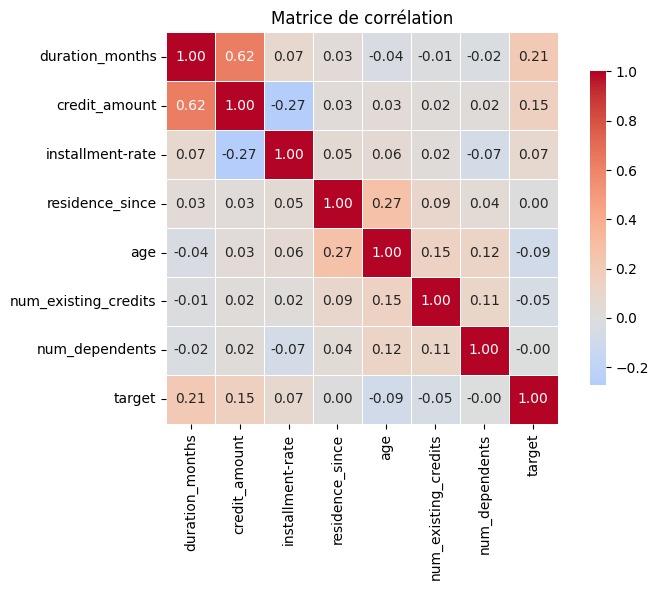

In [27]:
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,  square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Matrice de corrélation')
plt.tight_layout()
plt.show()


Il n'y a pas de mutlicolinéarité

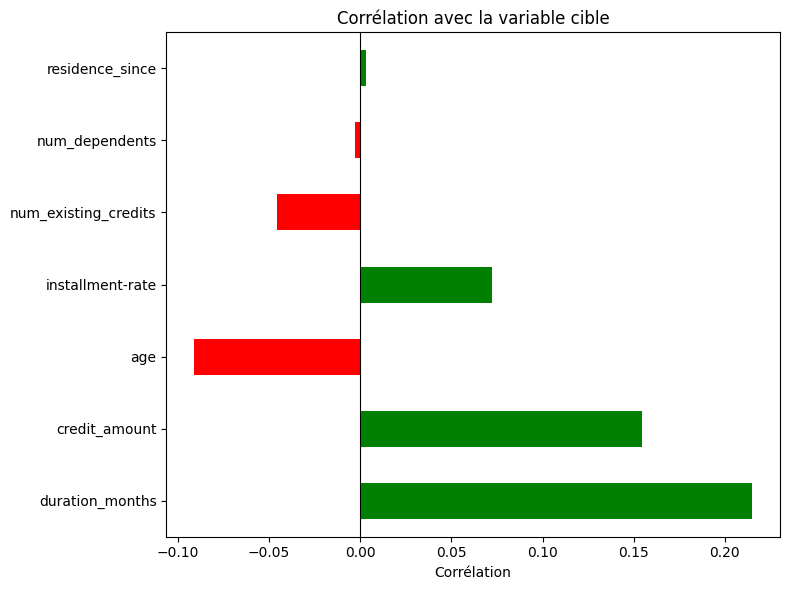

In [28]:
target_corr = corr_matrix['target'].drop('target').sort_values(key=abs, ascending=False)
plt.figure(figsize=(8,6))
target_corr.plot(kind='barh', color=['green' if x > 0 else 'red' for x in target_corr])
plt.title('Corrélation avec la variable cible')
plt.xlabel('Corrélation')
plt.axvline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()


Correlation faible avec la variable cible

# 4. PREPROCESSING (PIPELINE)

In [29]:
def preprocessing(dataframe):
    df = dataframe.copy()
    
    # séparer X et y
    X = df.drop('target', axis=1)
    y = df['target']
    
    # split
    X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # préserve les proportions désequilibrées
    )
    
    # X_train_processed = X_train.copy()
    # X_test_processed = X_test.copy()
    
    # percentiles = {}
    # for col in X.select_dtypes(include=[np.number]).columns.tolist():
    #     percentiles[col] = {
    #         'p01': X_train[col].quantile(0.01),
    #         'p99': X_train[col].quantile(0.99)
    #     }

    # # Appliquer winsorization
    # for col in X.select_dtypes(include=[np.number]).columns.tolist():
    #     # Train
    #     X_train_processed[col] = X_train_processed[col].clip(
    #         lower=percentiles[col]['p01'],
    #         upper=percentiles[col]['p99']
    #     )
    
    #     # Test (avec les percentiles du TRAIN)
    #     X_test_processed[col] = X_test_processed[col].clip(
    #         lower=percentiles[col]['p01'],
    #         upper=percentiles[col]['p99']
    #     )
    
    #     # Stats
    #     n_capped = ((X_train[col] < percentiles[col]['p01']) | 
    #                 (X_train[col] > percentiles[col]['p99'])).sum()
        
    #     if n_capped > 0:
    #         print(f"   {col:30s} : {n_capped:4d} valeurs cappées ({n_capped/len(X_train)*100:4.1f}%)")
    
    
    # X_train_fit, X_val, y_train_fit, y_val = train_test_split(
    # X_train_processed, y_train,
    # test_size=0.2,
    # random_state=42,
    # stratify=y_train
    # )
    
    print(f"\n✅ Split effectué (80/20)")
    print(f"   Train : {X_train.shape[0]}")
    print(f"   Test  : {X_test.shape[0]}")
    print(f"\n   Distribution Train :")
    print(f"     Classe 0 (Pas de défaut) : {(y_train==0).sum()} ({(y_train==0).mean():.1%})")
    print(f"     Classe 1 (Défaut)        : {(y_train==1).sum()} ({(y_train==1).mean():.1%})")
    # print(f"            Train (fit)  : {len(X_train_fit)}")
    # print(f"                Classe 0 (Pas de défaut) : {(y_train_fit==0).sum()} ({(y_train_fit==0).mean():.1%})")
    # print(f"                Classe 1 (Défaut)        : {(y_train_fit==1).sum()} ({(y_train_fit==1).mean():.1%})")
    # print(f"            Validation   : {len(X_val)}") 
    # print(f"                Classe 0 (Pas de défaut) : {(y_val==0).sum()} ({(y_val==0).mean():.1%})")
    # print(f"                Classe 1 (Défaut)        : {(y_val==1).sum()} ({(y_val==1).mean():.1%})") 
    print(f"   Distribution Test :")
    print(f"     Classe 0 (Pas de défaut) : {(y_test==0).sum()} ({(y_test==0).mean():.1%})")
    print(f"     Classe 1 (Défaut)        : {(y_test==1).sum()} ({(y_test==1).mean():.1%})")
    
        
    return X_train ,y_train, X_test, y_test
    

In [30]:
X_train ,y_train, X_test, y_test = preprocessing(df)


✅ Split effectué (80/20)
   Train : 800
   Test  : 200

   Distribution Train :
     Classe 0 (Pas de défaut) : 560 (70.0%)
     Classe 1 (Défaut)        : 240 (30.0%)
   Distribution Test :
     Classe 0 (Pas de défaut) : 140 (70.0%)
     Classe 1 (Défaut)        : 60 (30.0%)


## 4.1. PIPELINE NUMERIQUE

- traitement des outliers (si impact) --> risque d'overfitting
- feature engineering métier 
- transformation des distributions très asymétrique (si nécessaire) -->pour améliorer la performance

FEATURE ENGINEERING

In [31]:
numeric_cols

['duration_months',
 'credit_amount',
 'installment-rate',
 'residence_since',
 'age',
 'num_existing_credits',
 'num_dependents']

In [32]:
class CreditFeatureEngineer(BaseEstimator, TransformerMixin):
    """
    Transformer personnalisé pour feature engineering crédit
    
    Features créées (avec justifications métier) :
    
    1. monthly_payment = credit_amount / duration_months
       Mensualité approximative (charge mensuelle)
       
    2. credit_per_age = credit_amount / age
       Exposition relative à l'âge
       Jeune avec gros crédit = plus risqué
       
    3. young_high_credit = (age < 25) & (credit_amount > médiane)
       Flag segment très risqué
       Données historiques montrent défaut élevé
       
    4. dti_proxy = monthly_payment / income_proxy
       Debt-to-Income ratio approximatif
       Indicateur clé de capacité de remboursement
       
    5. duration_risk = duration_months / 12
       Risque augmente avec durée
       Linéarisation pour modèle
       
    6. log transformations (credit_amount, age)
       Réduction skewness
       Stabilisation variance
    """
    
    def __init__(self):
        self.median_credit_ = None
        self.median_age_ = None
    
    def fit(self, X, y=None):
        """Apprendre statistiques sur train"""
        if isinstance(X, pd.DataFrame):
            self.feature_names_in_ = X.columns.tolist()
            
            if 'credit_amount' in X.columns:
                self.median_credit_ = X['credit_amount'].median()
            
            if 'age' in X.columns:
                self.median_age_ = X['age'].median()
        else:
            self.feature_names_in_ = [f'feature_{i}' for i in range(X.shape[1])]
        
        return self
    
    def transform(self, X):
        """Créer features"""
        X_df = pd.DataFrame(X, columns=self.feature_names_in_)
        
        # Feature 1 : Mensualité
        if 'duration_months' in X_df.columns and 'credit_amount' in X_df.columns:
            X_df['monthly_payment'] = X_df['credit_amount'] / X_df['duration_months']
        
        # Feature 2 : Crédit par âge
        if 'credit_amount' in X_df.columns and 'age' in X_df.columns:
            X_df['credit_per_age'] = X_df['credit_amount'] / X_df['age']
        
        # Feature 3 : Jeune + haut crédit (segment risqué)
        if 'age' in X_df.columns and 'credit_amount' in X_df.columns:
            median_credit = self.median_credit_ if self.median_credit_ is not None else X_df['credit_amount'].median()
            X_df['young_high_credit'] = (
                (X_df['age'] < 25) & 
                (X_df['credit_amount'] > median_credit)
            ).astype(int)
        
        # Feature 4 : DTI proxy (approximatif car pas de revenu direct)
        if 'monthly_payment' in X_df.columns and 'installment_rate' in X_df.columns:
            # installment_rate = % du revenu mensuel disponible
            # Si installment_rate = 4 → 4% du revenu
            # monthly_payment / (installment_rate/100) ≈ revenu
            X_df['income_proxy'] = np.where(
                X_df['installment_rate'] > 0,
                X_df['monthly_payment'] / (X_df['installment_rate'] / 100),
                np.nan
            )
            X_df['dti_proxy'] = np.where(
                X_df['income_proxy'] > 0,
                X_df['monthly_payment'] / X_df['income_proxy'],
                np.nan
            )
        
        # Feature 5 : Duration en années (normalisation)
        if 'duration_months' in X_df.columns:
            X_df['duration_years'] = X_df['duration_months'] / 12
            # Catégories de durée
            X_df['duration_short'] = (X_df['duration_months'] <= 12).astype(int)
            X_df['duration_medium'] = ((X_df['duration_months'] > 12) & 
                                       (X_df['duration_months'] <= 24)).astype(int)
            X_df['duration_long'] = (X_df['duration_months'] > 24).astype(int)
        
        # Feature 6 : Log transformations (réduire skewness)
        # for col in ['credit_amount', 'age']:
        #     if col in X_df.columns:
        #         X_df[f'{col}_log'] = np.log1p(X_df[col])
        
        # Feature 7 : Âge catégorisé (patterns non-linéaires)
        if 'age' in X_df.columns:
            X_df['age_young'] = (X_df['age'] < 25).astype(int)
            X_df['age_prime'] = ((X_df['age'] >= 25) & (X_df['age'] <= 45)).astype(int)
            X_df['age_senior'] = (X_df['age'] > 45).astype(int)
        
        return X_df


In [33]:
numeric_transformer = Pipeline(steps=[
    ('feature_engineer', CreditFeatureEngineer())
])

## 4.2. PIPELINE CATEGORIELLE

ENCODING

In [34]:
cat_cols

['status_checking_account',
 'credit_history',
 'purpose',
 'savings_account',
 'employment_since',
 'personal_status_sex',
 'other_debtors',
 'property',
 'other_installment_plans',
 'housing',
 'job',
 'telephone',
 'foreign_worker']

In [35]:
cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

## 4.3. PIPELINE PREPROCESSOR

In [36]:
# columnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, make_column_selector(dtype_include=np.number)),
        ('cat', cat_transformer, make_column_selector(dtype_include="object"))
    ]
)

# 5. MODELISATION

## 5.1. PIPELINE COMPLET (PREPROCESSING + MODELE)

In [37]:
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('xgb', xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()
        # # architecture
        # n_estimators=500,
        # max_depth=6,
        # learning_rate=0.05,
        # # early_stopping_rounds=50,
    
        # # régularisation
        # reg_alpha=0.1,     # L1
        # reg_lambda=1.0,    # L2  
        # gamma=0.1,         # Min loss reduction
        # min_child_weight=5,
        
        # # sampling (réduction variance)
        # subsample=0.8,
        # colsample_bytree=0.8,
        
        # # déséquilibre
        # scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(), # ratio de déséquilibre
        
        # # autres
        # eval_metric='auc',
        # random_state=42,
        # n_jobs=-1,
        # tree_method='hist'  # plus rapide
    ))
])

## 5.2. ENTRAINEMENT

In [38]:
xgb_pipeline.fit(
    X_train, y_train,
    # xgb__eval_set=[(X_val, y_val)],
    xgb__verbose=False
)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('feature_engineer',
                                                                   CreditFeatureEngineer())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001EF4FD6D640>),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=None,
                               num_parallel_tree=None, ...))])

## 5.3. EVALUATION

In [45]:
# prédiction
y_proba_test = xgb_pipeline.predict_proba(X_test)[:, 1]
auc_xgb = roc_auc_score(y_test, y_proba_test)

print("AUC XGB:", auc_xgb)
print(classification_report(y_test, xgb_pipeline.predict(X_test)))

AUC XGB: 0.7953571428571429
              precision    recall  f1-score   support

           0       0.83      0.79      0.81       140
           1       0.56      0.63      0.59        60

    accuracy                           0.74       200
   macro avg       0.70      0.71      0.70       200
weighted avg       0.75      0.74      0.74       200



In [48]:
cm = confusion_matrix(y_test, xgb_pipeline.predict(X_test))
tn, fp, fn, tp = cm.ravel()
print(cm)

print(f"\n                     Prédit")
print(f"                Pas de défaut  Défaut")
print(f"Réel  Pas de défaut    {tn:4d}      {fp:4d}")
print(f"      Défaut        {fn:4d}      {tp:4d}")

print(f"\n   True Negatives  (TN) : {tn:4d} - Bien refusé mauvais client")
print(f"   False Positives (FP) : {fp:4d} - Refusé bon client (erreur Type I)")
print(f"   False Negatives (FN) : {fn:4d} - Accepté mauvais client (erreur Type II)")
print(f"   True Positives  (TP) : {tp:4d} - Bien accepté bon client")

[[110  30]
 [ 22  38]]

                     Prédit
                Pas de défaut  Défaut
Réel  Pas de défaut     110        30
      Défaut          22        38

   True Negatives  (TN) :  110 - Bien refusé mauvais client
   False Positives (FP) :   30 - Refusé bon client (erreur Type I)
   False Negatives (FN) :   22 - Accepté mauvais client (erreur Type II)
   True Positives  (TP) :   38 - Bien accepté bon client


In [ ]:
# tunning

param_grid = {
    "xgb__max_depth": [3, 4, 5],
    "xgb__learning_rate": [0.03, 0.05],
    "xgb__n_estimators": [200, 400],
    "xgb__subsample": [0.7, 0.8],
    "xgb__colsample_bytree": [0.7, 0.8]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    xgb_pipeline,
    param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('feature_engineer',
                                                                                          CreditFeatureEngineer())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001EF4FD6D640>),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(...
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=300,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'xgb__colsample_bytree': [0.7, 0.8],
                         'xgb__learning_rate': [0.03, 0.05],
                         'xgb__max_depth': [3, 4, 5],
                         'xgb__n_estimators': [200, 400],
                         'xgb__subsample': [0.7, 0.8]},
             scoring='roc_auc', verbose=1)

In [44]:
best_model = grid.best_estimator_

y_proba_test = best_model.predict_proba(X_test)[:, 1]
print("Best AUC:", roc_auc_score(y_test, y_proba_test))
print(f"Meilleurs paramètres : {grid.best_params_}")

Best AUC: 0.7970238095238095
Meilleurs paramètres : {'xgb__colsample_bytree': 0.7, 'xgb__learning_rate': 0.03, 'xgb__max_depth': 3, 'xgb__n_estimators': 400, 'xgb__subsample': 0.7}


In [51]:
# Train
y_proba_train = best_model.predict_proba(X_train)[:, 1]
auc_train = roc_auc_score(y_train, y_proba_train)

# Test
y_proba_test = best_model.predict_proba(X_test)[:, 1]
auc_test = roc_auc_score(y_test, y_proba_test)
gap = auc_train - auc_test

print("AUC train:", auc_train)
print("AUC test :", auc_test)
if gap < 0.02 :
    print("Très sain avec Gap      :", gap)
elif 0.02 < gap < 0.05 :
    print("Acceptable avec Gap      :", gap)
elif gap > 0.05 :
    print("Overfitting propable avec Gap      :", gap)


AUC train: 0.9678571428571429
AUC test : 0.7970238095238095
Overfitting propable avec Gap      : 0.1708333333333334


In [52]:
cv_scores = cross_val_score(
    best_model,
    X_train,
    y_train,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1
)

print("CV AUC mean:", cv_scores.mean())
print("CV AUC std :", cv_scores.std())
if cv_scores.std() < 0.02 :
    print("Modèle stable") # Un modèle instable = sur-apprentissage latent
elif cv_scores.std() > 0.03 :
    print("Dépend trop des splits") 

CV AUC mean: 0.7876860119047618
CV AUC std : 0.01853208890919079
Modèle stable


In [53]:
train_sizes, train_scores, val_scores = learning_curve(
    best_model,
    X_train,
    y_train,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

print("Train score end:", train_scores.mean(axis=1)[-1])
print("Val score end  :", val_scores.mean(axis=1)[-1])

if train_scores.mean(axis=1)[-1] > val_scores.mean(axis=1)[-1] :
    print("Overfitting")
elif train_scores.mean(axis=1)[-1] == val_scores.mean(axis=1)[-1] :
    print("Sain")
elif train_scores.mean(axis=1)[-1] < val_scores.mean(axis=1)[-1]:
    print('Bien mais vérifié si Train score n\'est pas basse')

Train score end: 0.9783458891369048
Val score end  : 0.7876860119047618
Overfitting


Overfitting --> à refaire

## 5.4. CALIBRATION ET INTERPRETATION

In [55]:
calibrated_model = CalibratedClassifierCV(
    best_model,
    method="isotonic",
    cv=3
)

calibrated_model.fit(X_train, y_train)

CalibratedClassifierCV(cv=3,
                       estimator=Pipeline(steps=[('preprocessor',
                                                  ColumnTransformer(transformers=[('num',
                                                                                   Pipeline(steps=[('feature_engineer',
                                                                                                    CreditFeatureEngineer())]),
                                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x000001EF4FC1EED0>),
                                                                                  ('cat',
                                                                                   Pipeline(steps=[('onehot',
                                                                                                    OneHotEncoder(drop='first',
                                                                                                                  handle_unknown='ignore'))]),
                                                                                   <skl...
                                                                grow_policy=None,
                                                                importance_type=None,
                                                                interaction_constraints=None,
                                                                learning_rate=0.03,
                                                                max_bin=None,
                                                                max_cat_threshold=None,
                                                                max_cat_to_onehot=None,
                                                                max_delta_step=None,
                                                                max_depth=3,
                                                                max_leaves=None,
                                                                min_child_weight=None,
                                                                missing=nan,
                                                                monotone_constraints=None,
                                                                multi_strategy=None,
                                                                n_estimators=400,
                                                                n_jobs=None,
                                                                num_parallel_tree=None, ...))]),
                       method='isotonic')

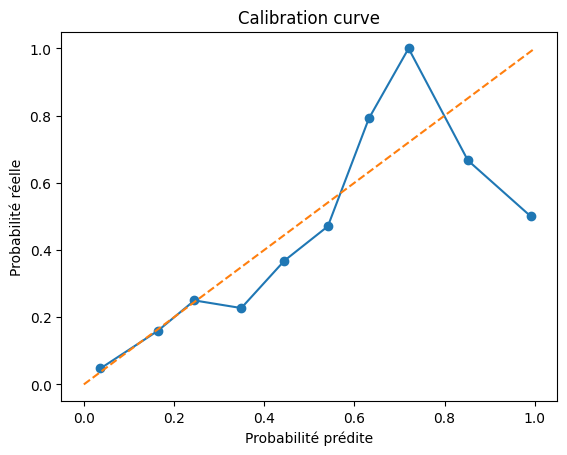

In [57]:
prob_true, prob_pred = calibration_curve(
    y_test,
    calibrated_model.predict_proba(X_test)[:, 1],
    n_bins=10
)

plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("Probabilité prédite")
plt.ylabel("Probabilité réelle")
plt.title("Calibration curve")
plt.show()

Plus proche de la diagonale = mieux

In [58]:
y_proba = calibrated_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Exemple : maximiser recall défaut sous pénalité FP
score = tpr - 0.3 * fpr
best_threshold = thresholds[np.argmax(score)]

print("Best threshold:", best_threshold)

Best threshold: 0.11257718751827876


In [59]:
y_pred_opt = (y_proba >= best_threshold).astype(int)

print(classification_report(y_test, y_pred_opt))

              precision    recall  f1-score   support

           0       0.95      0.30      0.46       140
           1       0.37      0.97      0.54        60

    accuracy                           0.50       200
   macro avg       0.66      0.63      0.50       200
weighted avg       0.78      0.50      0.48       200



Recall défaut ↑

Accuracy parfois ↓ (normal)

Mais performance métier ↑

In [60]:
# fonction coût bancaire 
def business_cost(y_true, y_pred):
    cost = 0
    for yt, yp in zip(y_true, y_pred):
        if yt == 1 and yp == 0:  # FN
            cost += 10000
        elif yt == 0 and yp == 1:  # FP
            cost += 1000
    return cost


costs = []

for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    costs.append(business_cost(y_test, y_pred))

best_t = thresholds[np.argmin(costs)]
print("Seuil métier optimal:", best_t)

Seuil métier optimal: 0.11257718751827876


In [67]:
# interprétation
calibrated_pipeline = calibrated_model.calibrated_classifiers_[0].estimator


# Extraire le modèle XGBoost entraîné
xgb_model = calibrated_pipeline.named_steps["xgb"]


# Récupérer les données transformées
X_train_transformed = calibrated_pipeline.named_steps["preprocessor"].transform(X_train)

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train_transformed)

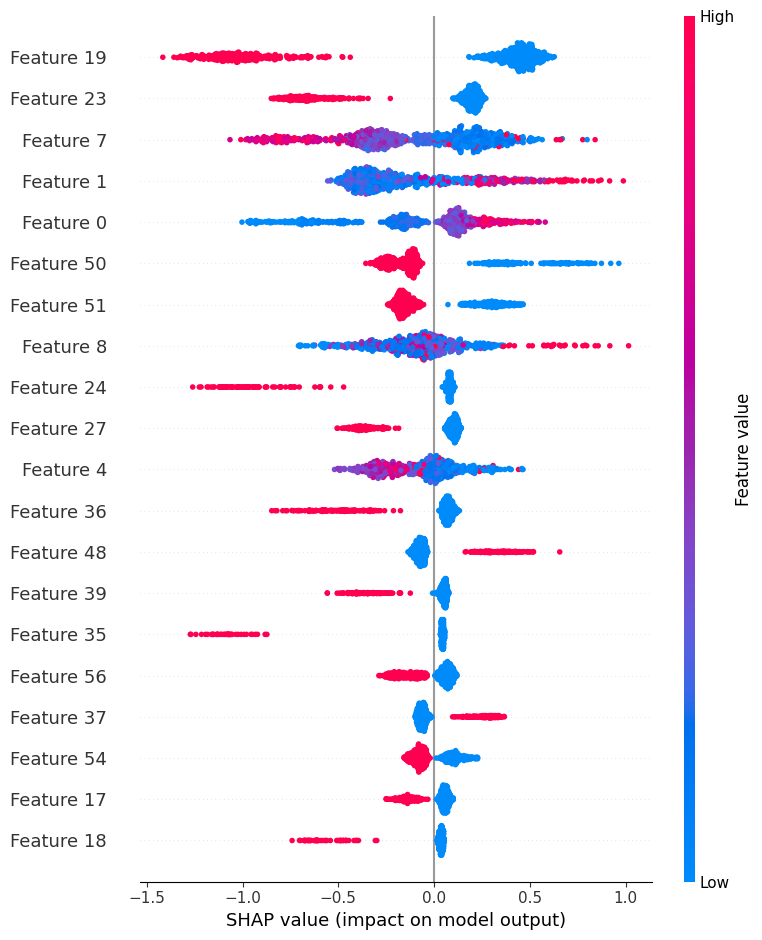

In [88]:
#importance globale

shap.summary_plot(shap_values, X_train_transformed)

Feature non connue --> gestion des colonnes --> à faire

debt_to_income ↑ → risque ↑

income ↑ → risque ↓

credit_utilization ↑ → risque ↑

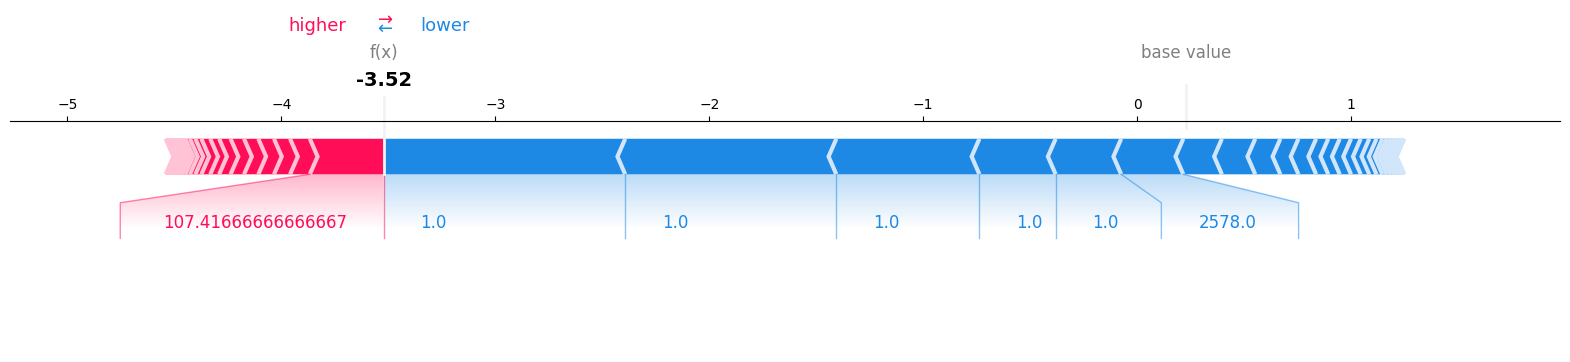

In [69]:
# local

i = 10  # client
shap.force_plot(
    explainer.expected_value,
    shap_values[i],
    X_train_transformed[i],
    matplotlib=True
)

In [72]:
mean_abs_shap = np.abs(shap_values).mean(axis=0)

## 5.5. TRANSFORMATION EN SCORECARD BANCAIRE

Passer de “probabilité ML” à un score compris entre 300 et 850

### Exemple


In [73]:
PDO = 50
B = PDO / np.log(2)
A = 600 + B * np.log(20)

In [75]:
# Transformation proba → score
def proba_to_score(p):
    odds = p / (1 - p)
    score = A - B * np.log(odds)
    return score

In [76]:
scores = proba_to_score(
    calibrated_model.predict_proba(X_test)[:, 1]
)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_6576\4258946641.py:4: RuntimeWarning: divide by zero encountered in log
  score = A - B * np.log(odds)


In [77]:
# décision
def decision(score):
    if score >= 750:
        return "Accepté"
    elif score >= 650:
        return "Accepté sous conditions"
    elif score >= 550:
        return "Surveillance"
    else:
        return "Refus"
